In [3]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.iclamp import IClamp
from icglm.kernels.fun import KernelFun
from icglm.kernels.rect import KernelRect
from icglm.models.glm import GLM
from icglm.plot.decoding import DecodingPlotter
from icglm.plot.fit import GLMPlotter
from icglm.processes import OUProcess
from icglm.spiketrain import SpikeTrain

%load_ext autoreload
%autoreload 2

### Loading and preprocessing patch clamp data

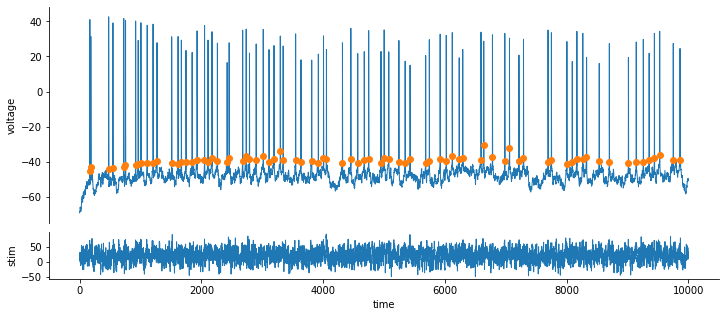

In [4]:
ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1)
ic.set_mask_spikes(thr=0, t_before_spike_peak=0.8)
ic = ic.subsample(1)

fig, axs = ic.plot(sweeps=[0], spikes=True)

### Fitting encoding GLM to data

Starting gradient ascent... 

 Iteration 7 of 30 | Elapsed time: 0.59 seconds | log_prior=nan | log_posterior=-3335.08
 
 Iteration 7 of 30 | Converged | Elapsed time: 0.0099 minutes | Log posterior is monotonic 



(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f576713b7b8>)

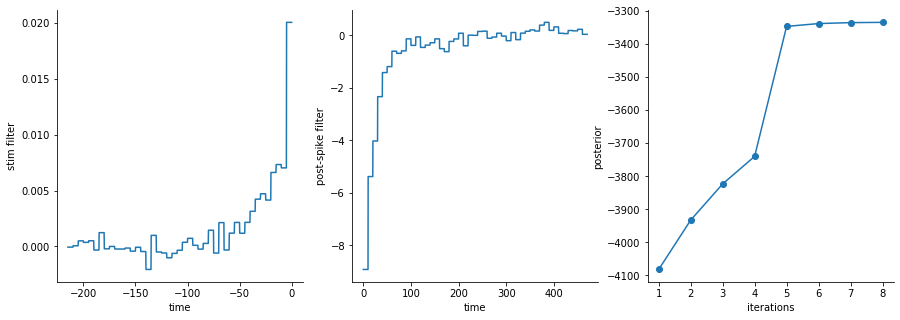

In [5]:
tbins_kappa = np.arange(0, 220, 5)
coefs_kappa0 = 1e-2 * np.exp(-tbins_kappa[:-1] / 50)
tbins_eta = np.arange(0, 480, 10)
coefs_eta0 = 6 * np.exp(-tbins_eta[:-1] / 50)
glm = GLM(u0=15, kappa=KernelRect(tbins_kappa, coefs_kappa0), eta=KernelRect(tbins_eta, coefs_eta0))

newton_kwargs = dict(max_iterations=30, stop_cond=5e-4, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)
optimizer = glm.fit(ic.t, ic.stim, ic.mask_spikes, newton_kwargs=newton_kwargs, verbose=True)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
glm_plotter = GLMPlotter(ic=ic, model=glm, optimizer=optimizer)
glm_plotter.plot_filters(axs=(ax1, ax2))
glm_plotter.plot_posterior_iterations(ax=ax3)

/home/diego/anaconda3/envs/hold_noise/lib/python3.7/site-packages/IPython/core/events.py:88: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


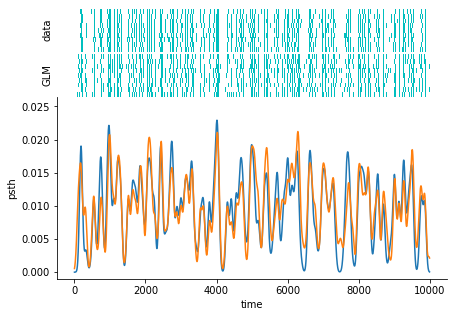

In [6]:
psth_kernel = KernelFun.gaussian_delta(delta=40)
v, r, mask_spikes = glm.sample(ic.t, ic.stim)
glm_plotter.mask_spikes_model = mask_spikes
glm_plotter.psth_model = SpikeTrain(ic.t, mask_spikes).get_psth(psth_kernel)
glm_plotter.psth_exp = SpikeTrain(ic.t, ic.mask_spikes).get_psth(psth_kernel)

fig, axs = glm_plotter.plot_raster()

### Decoding stimulus from spike data and GLM

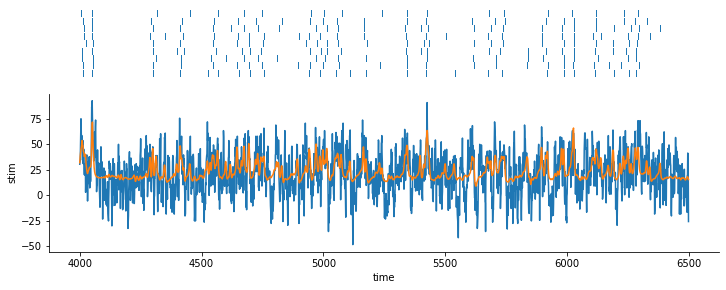

In [39]:
mu, sd = np.mean(ic.stim), np.mean(np.std(ic.stim, 0))
ou = OUProcess(mu=mu, sd=sd, tau=3)
stim_true = ic.stim[:, 0]
stim0 = np.zeros(len(ic.t)) + mu

newton_kwargs = dict(learning_rate=1e-1, stop_cond=2e-6, max_iterations=20)

stim_dec, optimizer = glm.decode(ic.t, ic.mask_spikes, stim0=stim0, prior=ou, newton_kwargs=newton_kwargs)

dec_plotter = DecodingPlotter(t=ic.t, model=[glm], optimizer=optimizer, mask_spikes=[ic.mask_spikes], stim_dec=stim_dec, stim_true=stim_true)
fig, axs = dec_plotter.plot_decoded_stimulus(t0=4000, tf=6500)

In [40]:
from icglm.metrics.decoding import log_det_from_banded_cholesky
from scipy.linalg import cholesky_banded

h_log_posterior_banded = optimizer.h_log_posterior
inv_cov_banded_cholesky = cholesky_banded(-h_log_posterior_banded, lower=True)
cov_log_determinant = -log_det_from_banded_cholesky(inv_cov_banded_cholesky)
log_det_cov_prior = ou.log_det_prior_covariance(stim_true, 1)
print(cov_log_determinant, log_det_cov_prior)
print(0.5 * (log_det_cov_prior - cov_log_determinant))

51809.26177437015 53054.34724842726
622.5427370285543


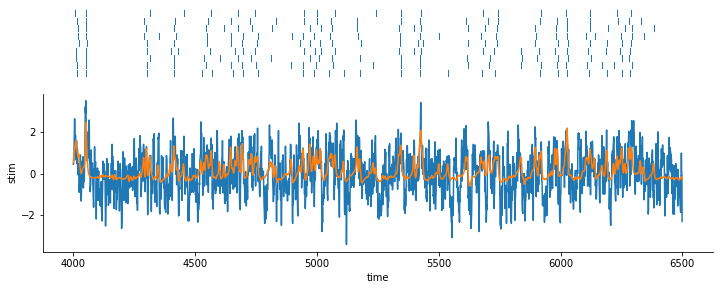

In [41]:
mu, sd = np.mean(ic.stim), np.mean(np.std(ic.stim, 0))
ou = OUProcess(mu=0, sd=1, tau=3)
stim_true = (ic.stim[:, 0] - mu) / sd
stim0 = np.zeros(len(ic.t))

newton_kwargs = dict(learning_rate=1e-1, stop_cond=2e-6, max_iterations=20)

stim_dec, optimizer = glm.decode(ic.t, ic.mask_spikes, stim0=stim0, mu_stim=mu, sd_stim=sd, 
                                 prior=ou, newton_kwargs=newton_kwargs)

dec_plotter = DecodingPlotter(t=ic.t, model=[glm], optimizer=optimizer, mask_spikes=[ic.mask_spikes], 
                              stim_dec=stim_dec, stim_true=stim_true)
fig, axs = dec_plotter.plot_decoded_stimulus(t0=4000, tf=6500)

In [42]:
from icglm.metrics.decoding import log_det_from_banded_cholesky
from scipy.linalg import cholesky_banded

h_log_posterior_banded = optimizer.h_log_posterior
inv_cov_banded_cholesky = cholesky_banded(-h_log_posterior_banded, lower=True)
cov_log_determinant2 = -log_det_from_banded_cholesky(inv_cov_banded_cholesky)
log_det_cov_prior2 = ou.log_det_prior_covariance(stim_true, 1)
print(cov_log_determinant2, log_det_cov_prior2)
print(0.5 * (log_det_cov_prior2 - cov_log_determinant2))

-8447.845427679404 -7202.759953622317
622.5427370285433
